# Edinburgh cycle hire data

***Note:*** there is an error in the video -- I mixed up latitude and longitude! The correction was added in this notebook.

---

Until a few weeks ago (unfortunately!), Edinburgh had a bike hire scheme, where you could rent a bike from one station to another. The company which ran the scheme published anonymised data every month, containing all information about the bike trips people have made that month.

All available data files (since the scheme started in September 2018) are available [here](https://edinburghcyclehire.com/open-data/historical), as well as a description of the data. It is published under the [Open Government License (OGL)](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

This follows on from the Tuesday week 8 session. The file `07.csv` containing the data for July 2021 is also included in the repo, if you'd like to reproduce the results below on more recent data. The data used in the videos is from October 2020 (`10.csv`).

---

Some questions we could investigate:

- What is the average journey time and distance of bike trips on weekdays? What about weekends?
- How many stations appear in the dataset? Which were the most common starting stations?
- What was the most common time(s) of day for journeys to be undertaken?

---

Useful documentation:

- [`pandas.to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html?highlight=to_datetime#pandas.to_datetime)
- [The `.dt` accessor](https://pandas.pydata.org/docs/user_guide/basics.html#dt-accessor)
- [Time and date components](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components)
- Relational plots: [`sns.relplot()`](https://seaborn.pydata.org/generated/seaborn.relplot.html)
- Categorical plots: [`sns.catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html)
- Distribution plots: [`sns.displot()`](https://seaborn.pydata.org/generated/seaborn.displot.html)

In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('10.csv')
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['weekday'] = df['started_at'].dt.dayofweek
df.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,weekday
0,2020-10-01 01:50:02.035000+00:00,2020-10-01 02:19:36.385000+00:00,1774,1050,EICC,Outside Edinburgh International Conference Centre,55.946071,-3.210396,1102,Haymarket Station,Haymarket Station,55.945569,-3.218185,3
1,2020-10-01 02:07:21.040000+00:00,2020-10-01 02:53:34.548000+00:00,2773,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,3
2,2020-10-01 02:08:37.692000+00:00,2020-10-01 03:05:53.355000+00:00,3435,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,3
3,2020-10-01 04:25:54.283000+00:00,2020-10-01 04:45:12.275000+00:00,1157,256,St Andrews House,beside Jacobs ladder,55.953164,-3.181682,1025,Dundee Terrace,Corner of Dundee Street & Dundee Terrace,55.939710,-3.220589,3
4,2020-10-01 04:35:56.950000+00:00,2020-10-01 04:51:02.609000+00:00,905,1102,Haymarket Station,Haymarket Station,55.945569,-3.218185,262,Canonmills,near Tesco's,55.962804,-3.196284,3


In [19]:
df.groupby('weekday')['duration'].mean()

weekday
0    1446.354631
1    1422.154019
2    1465.192293
3    1401.003233
4    1524.083398
5    1786.042790
6    2091.283338
Name: duration, dtype: float64

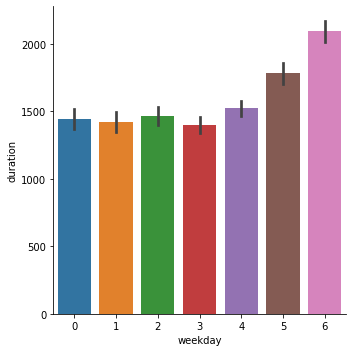

In [2]:
sns.catplot(data=df,
            x='weekday',
            y='duration',
            kind='bar')

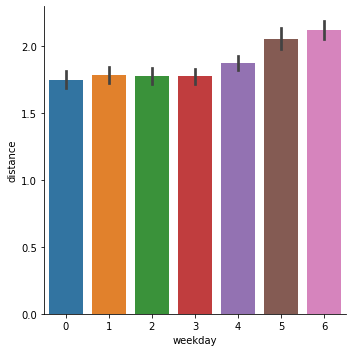

In [3]:
# From https://stackoverflow.com/a/21623206
# User: Salvador Dali

import numpy as np

def distance(lat1, lon1, lat2, lon2):
    '''
    Calculate the Haversine distance between 2 points.
    Returns the distance in km.
    '''
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 12742 * np.arcsin(np.sqrt(a))

df['distance'] = distance(df['start_station_latitude'],
                          df['start_station_longitude'],
                          df['end_station_latitude'],
                          df['end_station_longitude'])

sns.catplot(data=df,
            x='weekday',
            y='distance',
            kind='bar')

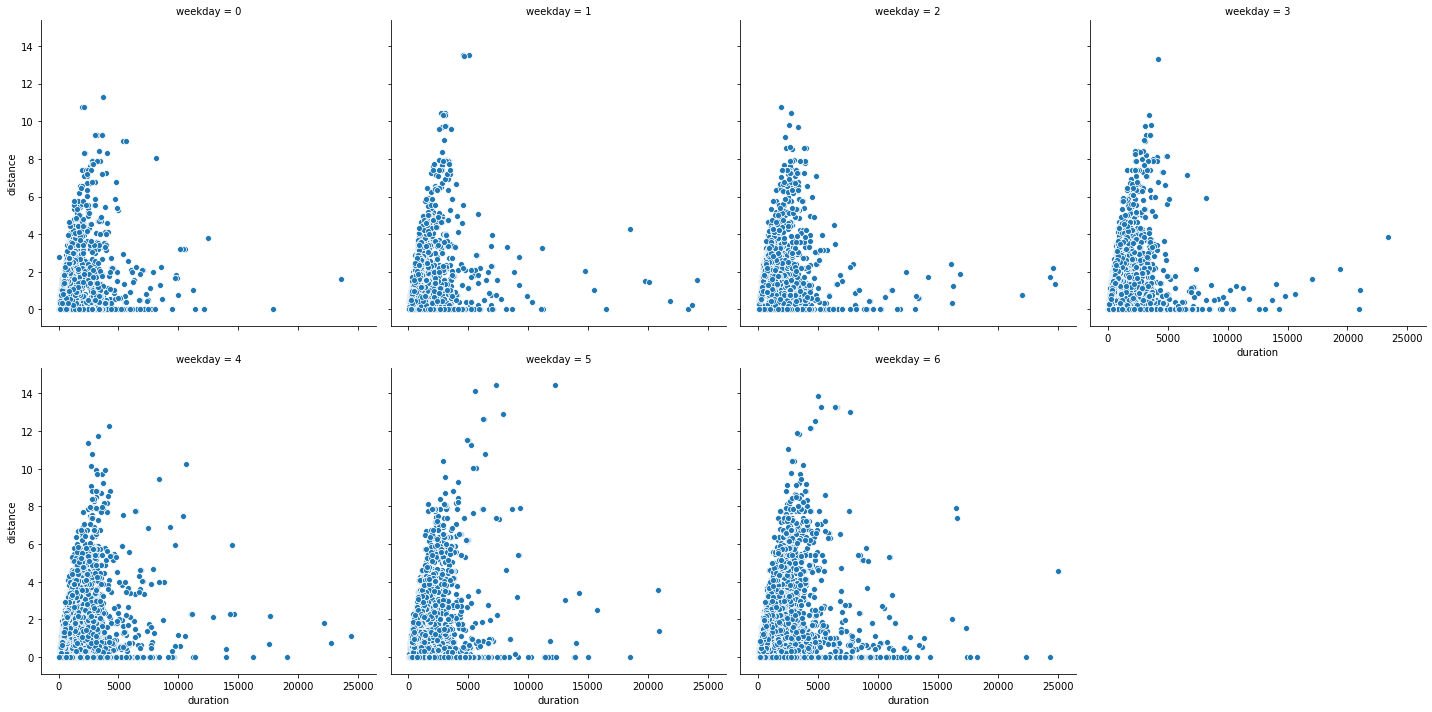

In [4]:
sns.relplot(data=df,
            x='duration',
            y='distance',
            kind='scatter',
            col='weekday',
            col_wrap=4)

In [9]:
# How many stations?
df['start_station_name'].nunique()

111

In [10]:
df['start_station_name'].value_counts()

Meadows East                                883
Meadow Place                                632
Waverley Bridge                             454
Bruntsfield Links                           454
Leith Walk                                  451
                                           ... 
Sighthill - Edinburgh College                10
Edinburgh Park Central                        9
Scotstoun House                               2
Picady Place                                  1
Eden Locke - Aparthotel (RESIDENTS ONLY)      1
Name: start_station_name, Length: 111, dtype: int64

<IPython.core.display.Javascript object>


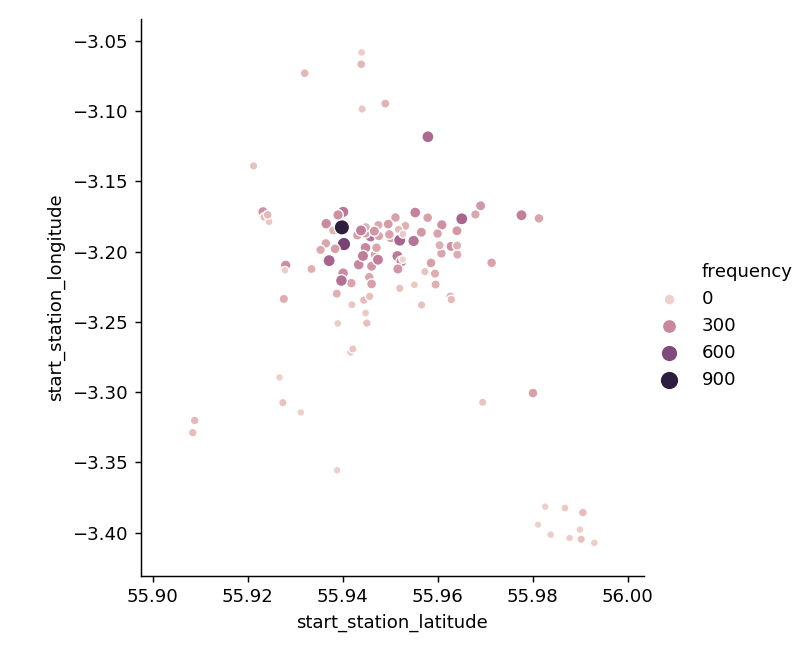

In [18]:
# Getting station information with groupby
station_groups = df.groupby('start_station_name')
station_info = pd.DataFrame()

for column in ['start_station_name', 'start_station_latitude', 'start_station_longitude']:
    station_info[column] = station_groups[column].first()

station_info['frequency'] = df['start_station_name'].value_counts()

%matplotlib notebook
sns.relplot(data=station_info,
            kind='scatter',
            x='start_station_latitude',
            y='start_station_longitude',
            hue='frequency',
            size='frequency')

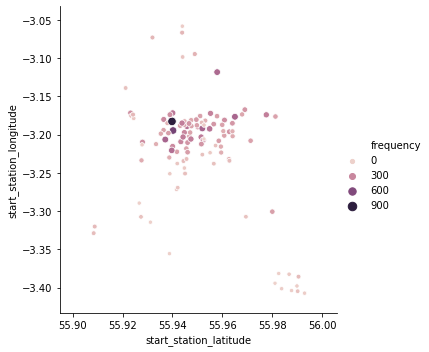

In [39]:
# I forgot to do it with a pivot table in the video -- here it is!
# pivot_table() seems to work well when using unique().
station_pivot = df.pivot_table(index='start_station_name',
                               values=['start_station_latitude',
                                        'start_station_longitude'],
                               aggfunc={'start_station_name': pd.Series.value_counts,
                                        'start_station_latitude': pd.Series.unique,
                                        'start_station_longitude': pd.Series.unique})

# Rename the 'start_station_name' column
station_pivot.rename(columns={'start_station_name': 'frequency'}, inplace=True)
station_pivot

sns.relplot(data=station_pivot,
            kind='scatter',
            x='start_station_latitude',
            y='start_station_longitude',
            hue='frequency',
            size='frequency')

### Erratum

It turns out that [I was completely wrong on the station locations](https://edinburghcyclehire.com/stations) -- this is the risk when you don't overlay a map! :)

Latitude is of course the x-axis and longitude the y-axis. Here's the correct version (also with an accurate aspect ratio):

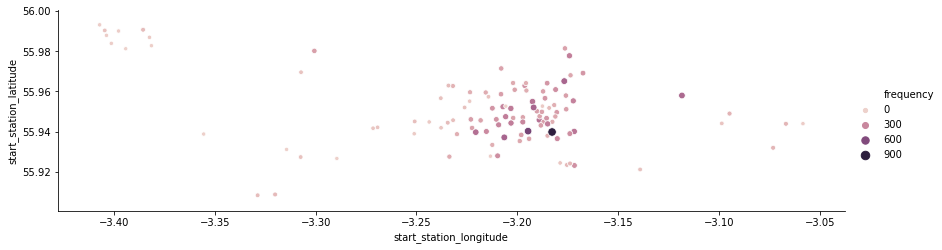

In [51]:
%matplotlib inline
g = sns.relplot(data=station_pivot,
                kind='scatter',
                x='start_station_longitude',
                y='start_station_latitude',
                hue='frequency',
                size='frequency',
                height=12)

# Get the Axes object using g.ax
g.ax.set_aspect('equal')